กลุ่ม H2C

In [ ]:
# นำเข้าโมดูล
import time  
import robomaster
from robomaster import robot
import csv
from datetime import datetime

# เชื่อมต่อกับหุ่นยนต์
if __name__ == '__main__':
    ep_robot = robot.Robot()
    ep_robot.initialize(conn_type="ap")

    # สร้างตัวควบคุม Gimbal เข้าถึง Object ของ Gimbal จาก Object ของหุ่นยนต์
    ep_gimbal = ep_robot.gimbal


    # สร้างชื่อไฟล์ CSV พร้อม timestamp
    filename = datetime.now().strftime("gimbal_data.csv")

# สร้างชื่อไฟล์ gimbal_data.csv ตามเวลาที่รันโปรแกรม
    with open(filename, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        # เขียนหัวข้อคอลัมน์ในไฟล์ CSV
        csv_writer.writerow(['timestamp', 'pitch_angle', 'yaw_angle', 'pitch_ground_angle', 'yaw_ground_angle'])

        start_time = time.time()

        # กำหนดฟังก์ชันสำหรับการ subscribe ข้อมูลมุม
        # ฟังก์ชัน Callback จะถูกเรียกใช้ทุกครั้งที่ได้รับข้อมูลมุม Gimbal ใหม่จากหุ่นยนต์
        def sub_data_handler(angle_info): 
            pitch_angle, yaw_angle, pitch_ground_angle, yaw_ground_angle = angle_info
            # pitch_angle, yaw_angle, pitch_ground_angle, yaw_ground_angle = angle_info ข้อมูลมุมจะถูกส่งมาในรูปของ tuple angle_info ซึ่งทำการ Unpack ออกเป็นตัวแปรแต่ละตัว
            timestamp = time.time()
            # timestamp จะถูกบันทึกเป็นเวลาปัจจุบันในรูปแบบของ timestamp
            # บันทึกข้อมูลลงในไฟล์ CSV
            csv_writer.writerow([timestamp, pitch_angle, yaw_angle, pitch_ground_angle, yaw_ground_angle])
            # ยังคงแสดงผลทางคอนโซลเพื่อการตรวจสอบ
            print("gimbal angle: pitch_angle:{0}, yaw_angle:{1}, pitch_ground_angle:{2}, yaw_ground_angle:{3}".format(
                pitch_angle, yaw_angle, pitch_ground_angle, yaw_ground_angle))
        
        # คำสั่งควบคุมการเคลื่อนที่ของ gimbal
        ep_gimbal.sub_angle(freq=5, callback=sub_data_handler)

        ep_gimbal.moveto(pitch=0, yaw=0).wait_for_completed()
        ep_gimbal.moveto(pitch=0, yaw=90, pitch_speed=50, yaw_speed=30).wait_for_completed()
        ep_gimbal.moveto(pitch=0, yaw=-90, pitch_speed=100, yaw_speed=30).wait_for_completed()
        ep_gimbal.moveto(pitch=0, yaw=0).wait_for_completed()
        # subscribe ข้อมูลมุมด้วยความถี่ 5 Hz
        # pitch มุม Pitch ที่ต้องการ (หน่วยเป็นองศา) โดยจะกำหนดให้เป็น 0 องศา เพ่ื่อให้ gimbal ขนานกับพื้น
        # yaw มุม Yaw ที่ต้องการ (หน่วยเป็นองศา)
        # pitch_speed ความเร็วในการหมุน Pitch (หน่วยเป็นองศาต่อวินาที)
        # yaw_speed ความเร็วในการหมุน Yaw (หน่วยเป็นองศาต่อวินาที)
        # คำสั่ง moveto จะทำให้ gimbal หมุนไปยังมุม
        # wait_for_completed จะรอให้การเคลื่อนที่เสร็จสิ้นก่อนที่จะดำเนินการต่อไป

        # ยกเลิกการ subscribe ข้อมูลมุม
        ep_gimbal.unsub_angle()

    # ปิดการเชื่อมต่อหุ่นยนต์
    ep_robot.close()
    

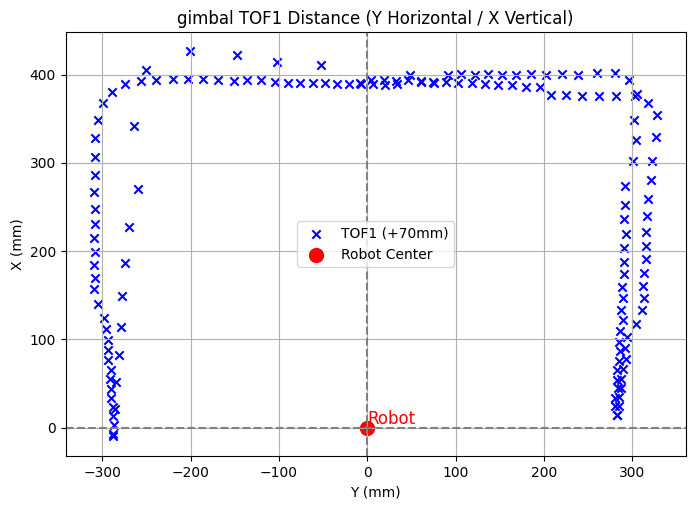

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# โหลดข้อมูลจากไฟล์ CSV
file_path = "../data/gimbal_tof_data_2.csv"  # เปลี่ยน path ตามไฟล์ที่ต้องการอ่าน
df = pd.read_csv(file_path)

# กรองเฉพาะค่าที่ tof1 มีระยะมากกว่า 0 (เพื่อไม่ plot ค่าที่วัดไม่ได้)
# เป็นขั้นตอนที่สำคัญสำหรับการทำความสะอาดข้อมูล เซ็นเซอร์ TOF บางครั้งอาจส่งค่า 0 หรือค่าลบกลับมาหากไม่สามารถอ่านค่าที่ถูกต้องได้
valid_data = df[df['tof1'] > 0]

# แปลง yaw_ground_angle จากองศาเป็นเรเดียน
angles_rad = np.deg2rad(valid_data['yaw_ground_angle'].values)
# ดึงค่าการวัดระยะทาง tof1 (Time-of-Flight 1) จากข้อมูล
distances = valid_data['tof1'].values

# เพิ่มระยะอีก 7 cm (70 mm) การที่เราเพิ่ม 70 mm เข้าไป ก็คือการชดเชย ระยะที่เซ็นเซอร์มันยื่นออกมาจากจุดศูนย์กลางการหมุน เพื่อให้ค่าระยะทางที่เรานำไปคำนวณเป็นพิกัด (X, Y) นั้นเป็นระยะที่ถูกต้องเมื่อเทียบกับจุดศูนย์กลางของหุ่นยนต์
distances = distances + 70

# แปลงเป็นพิกัด x, y (หุ่นอยู่ที่จุดศูนย์กลาง)
x = distances * np.cos(angles_rad)
y = distances * np.sin(angles_rad)

# สร้างกราฟ XY โดยสลับแกน (แนวนอนเป็น y, แนวตั้งเป็น x)
plt.figure(figsize=(8, 8))
# กำหนดขนาดกราฟให้เป็น 8x8 นิ้ว
plt.scatter(y, x, c='blue', label='TOF1 (+70mm)', marker='x')
# ใช้ scatter plot เพื่อแสดงจุดข้อมูล โดยใช้ y เป็นแกนแนวนอนและ x เป็นแกนแนวตั้ง

# เพิ่มจุดตำแหน่งหุ่นยนต์ (0,0)
plt.scatter(0, 0, c='red', s=100, label='Robot Center', marker='o')
plt.text(0, 0, "Robot", color='red', fontsize=12, ha='left', va='bottom')

plt.xlabel("Y (mm)")
# ระบุแกนแนวนอน (y) ให้แสดงเป็นระยะทางในหน่วยมิลลิเมตร
plt.ylabel("X (mm)")
# ระบุแกนแนวตั้ง (x) ให้แสดงเป็นระยะทางในหน่วยมิลลิเมตร
plt.title("gimbal TOF1 Distance (Y Horizontal / X Vertical)")
# กำหนดชื่อกราฟฟห
plt.axhline(0, color='gray', linestyle='--')
# วาดเส้นแนวนอนที่แกน x = 0 เพื่อแสดงจุดศูนย์กลาง
plt.axvline(0, color='gray', linestyle='--')
# วาดเส้นแนวตั้งที่แกน y = 0 เพื่อแสดงจุดศูนย์กลาง
plt.gca().set_aspect('equal', adjustable='box')
# กำหนดอัตราส่วนของแกนให้เท่ากันเพื่อให้กราฟไม่บิดเบือน
plt.legend()
# แสดงตำนานของกราฟ
plt.grid(True)
# แสดงกริดในกราฟ
plt.show()